In [1]:
import numpy as np 
import pandas as pd 

train = pd.read_csv('./data/digits.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
y_train = train['label'].to_numpy()
x_train = train.drop(['label'], axis=1).astype('float32').to_numpy()

# AlexNet

## Reshaping
LeNet - 5 operates on (n,n,1) array so we need to reshape our training data.

In [3]:
x_train_img = x_train.reshape((x_train.shape[0], 28, 28, 1))

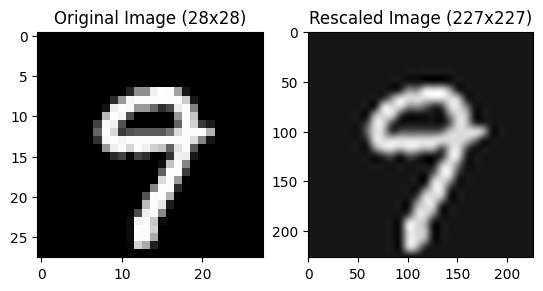

In [4]:
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Assuming your original image is 'original_image' with shape (28, 28)
original_image = x_train_img[213].reshape((28,28))

# Define the scaling factor for each dimension
scaling_factors = (227 / 28, 227 / 28)


# Use scipy.ndimage.zoom to rescale the image
rescaled_image = zoom(original_image, scaling_factors, mode='nearest')

# Display the original and rescaled images for comparison
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image (28x28)')

plt.subplot(1, 2, 2)
plt.imshow(rescaled_image, cmap='gray')
plt.title('Rescaled Image (227x227)')

plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class ImageScalingLayer(Layer):
    def __init__(self, scale_factor, **kwargs):
        super(ImageScalingLayer, self).__init__(**kwargs)
        self.scale_factor = scale_factor

    def build(self, input_shape):
        super(ImageScalingLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        # Assuming 'inputs' is a 4D tensor with shape (batch_size, height, width, channels)
        height, width = tf.shape(inputs)[1], tf.shape(inputs)[2]
        new_height = tf.cast(tf.cast(height, tf.float32) * self.scale_factor, tf.int32)
        new_width = tf.cast(tf.cast(width, tf.float32) * self.scale_factor, tf.int32)

        # Using tf.image.resize for bilinear interpolation
        scaled_images = tf.image.resize(inputs, size=(new_height, new_width), method=tf.image.ResizeMethod.BILINEAR)
        
        return scaled_images

    def compute_output_shape(self, input_shape):
        new_height = int(input_shape[1] * self.scale_factor)
        new_width = int(input_shape[2] * self.scale_factor)
        return (input_shape[0], new_height, new_width, input_shape[3])


## Train

In [6]:
import tensorflow as tf
import tensorflow.keras.layers as layers

model = tf.keras.Sequential([
    ImageScalingLayer(scale_factor=227/28),
    layers.Conv2D(filters=96, kernel_size=11, strides=4),
    layers.MaxPooling2D(pool_size=3, strides=2),
   
    layers.Conv2D(filters=256, kernel_size=5, padding='same'),
    layers.MaxPooling2D(pool_size=3, strides=2),

    layers.Conv2D(filters=384, kernel_size=3, padding='same'),
    layers.Conv2D(filters=384, kernel_size=3, padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, padding='same'),
    layers.MaxPooling2D(pool_size=3, strides=2),

    layers.Flatten(),

    layers.Dense(9216, kernel_regularizer=tf.keras.regularizers.L2(0.001), activation='relu'),
    layers.Dense(4096, kernel_regularizer=tf.keras.regularizers.L2(0.001), activation='relu'),
    layers.Dense(4096, kernel_regularizer=tf.keras.regularizers.L2(0.001), activation='relu'),

    layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train_img, y_train, validation_split=0.01, epochs=50)

Epoch 1/50
1300/1300 [==============================] - 41s 28ms/step - loss: 15.7477 - accuracy: 0.9504 - val_loss: 14.4578 - val_accuracy: 0.9786
Epoch 2/50
1300/1300 [==============================] - 36s 28ms/step - loss: 13.6236 - accuracy: 0.9844 - val_loss: 12.8820 - val_accuracy: 0.9810
Epoch 3/50
1300/1300 [==============================] - 35s 27ms/step - loss: 12.1407 - accuracy: 0.9884 - val_loss: 11.4259 - val_accuracy: 0.9833
Epoch 4/50
1300/1300 [==============================] - 35s 27ms/step - loss: 10.6862 - accuracy: 0.9927 - val_loss: 9.9476 - val_accuracy: 0.9905
Epoch 5/50
1300/1300 [==============================] - 37s 29ms/step - loss: 9.1787 - accuracy: 0.9922 - val_loss: 8.4202 - val_accuracy: 0.9952
Epoch 6/50
1300/1300 [==============================] - 36s 28ms/step - loss: 7.6753 - accuracy: 0.9944 - val_loss: 6.9523 - val_accuracy: 0.9881
Epoch 7/50
1300/1300 [==============================] - 36s 28ms/step - loss: 6.2135 - accuracy: 0.9950 - val_loss: 5

<Axes: >

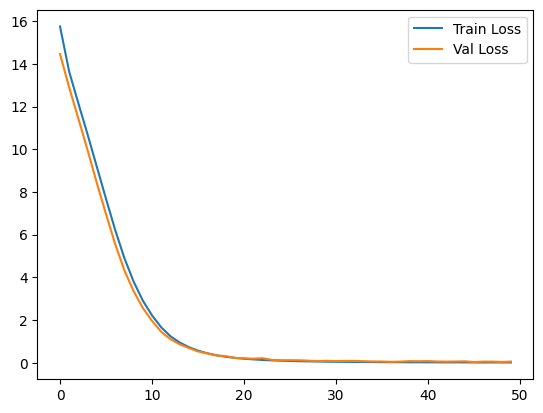

In [7]:
import seaborn as sns

loss = hist.history['loss']
val_loss = hist.history['val_loss']
sns.lineplot(loss, label='Train Loss')
sns.lineplot(val_loss, label='Val Loss')

<Axes: >

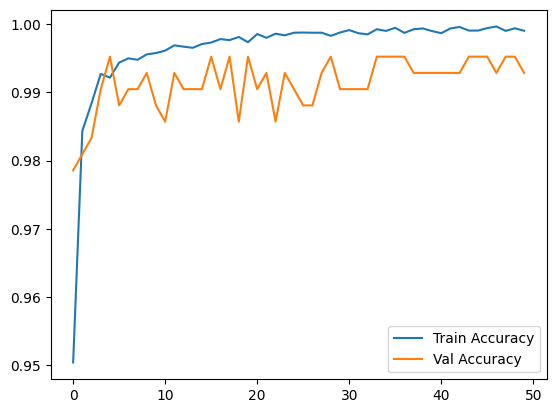

In [8]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
sns.lineplot(acc, label='Train Accuracy')
sns.lineplot(val_acc, label='Val Accuracy')

The loss curve looks so much better than the previous iteration. If we examine the loss curve starting from 20th epoch, we can see that we probably can reach lower loss if we train longer.

<Axes: >

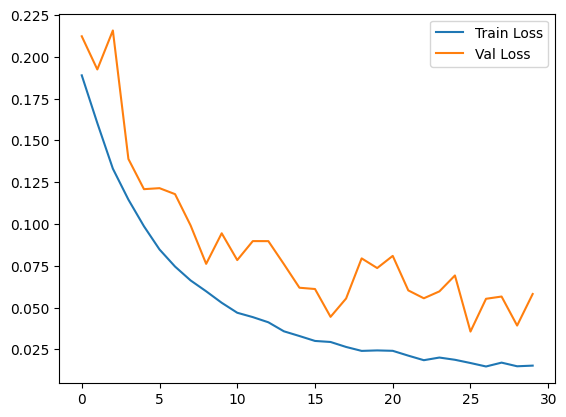

In [9]:
sns.lineplot(loss[20:], label='Train Loss')
sns.lineplot(val_loss[20:], label='Val Loss')

In [11]:
hist2 =  model.fit(x_train_img, y_train, validation_split=0.01, epochs=100, initial_epoch=hist.epoch[-1])

Epoch 50/100
1300/1300 [==============================] - 37s 29ms/step - loss: 0.0152 - accuracy: 0.9990 - val_loss: 0.0479 - val_accuracy: 0.9952
Epoch 51/100
1300/1300 [==============================] - 37s 29ms/step - loss: 0.0132 - accuracy: 0.9994 - val_loss: 0.0564 - val_accuracy: 0.9929
Epoch 52/100
1300/1300 [==============================] - 38s 29ms/step - loss: 0.0135 - accuracy: 0.9992 - val_loss: 0.0614 - val_accuracy: 0.9929
Epoch 53/100
1300/1300 [==============================] - 37s 28ms/step - loss: 0.0132 - accuracy: 0.9993 - val_loss: 0.0537 - val_accuracy: 0.9929
Epoch 54/100
1300/1300 [==============================] - 37s 29ms/step - loss: 0.0115 - accuracy: 0.9996 - val_loss: 0.0421 - val_accuracy: 0.9952
Epoch 55/100
1300/1300 [==============================] - 37s 29ms/step - loss: 0.0130 - accuracy: 0.9991 - val_loss: 0.0423 - val_accuracy: 0.9976
Epoch 56/100
1300/1300 [==============================] - 37s 29ms/step - loss: 0.0094 - accuracy: 1.0000 - val_

<Axes: >

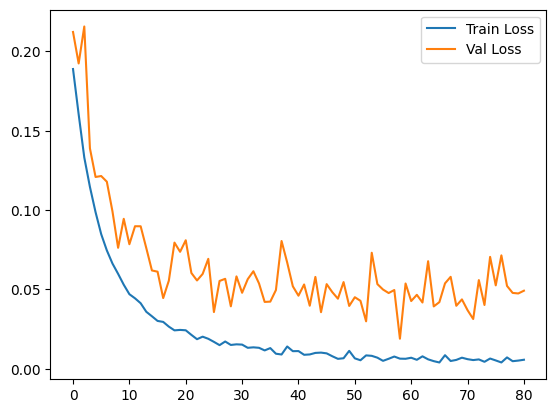

In [12]:
sns.lineplot(loss[20:] + hist2.history['loss'], label='Train Loss')
sns.lineplot(val_loss[20:]  + hist2.history['val_loss'], label='Val Loss')

It actually does not seem to help. Val loss and train loss diverges so maybe we need to employ data augmentation.

## Predict

In [13]:
y_pred = model.predict(x_train_img)
y_class = np.argmax(y_pred, axis=1)
accu = np.mean(y_class == y_train)
print(f'Accuracy {round(accu * 100, 2)}%')

1313/1313 [==============================] - 10s 8ms/step
Accuracy 99.99%


## Submission

In [ ]:
test = pd.read_csv('./digits-test.csv')
test['id'] = test.index + 1

test_img = test.drop('id', axis=1).astype('float32').to_numpy().reshape((test.shape[0], 28,28,1))

In [ ]:
y_pred_test = model.predict(test_img)
y_class_test = np.argmax(y_pred_test, axis=1)

output = pd.DataFrame({'ImageId': test.id, 'Label': y_class_test})
output.to_csv('submission-regularized.csv', index=False)

875/875 [==============================] - 7s 8ms/step
